In [1]:
# !gdown https://drive.google.com/uc?id=1dXD4MIzHgJ31xVGfDdBx0cgwZs1_W589

In [2]:
# !unzip /content/rps.zip

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [4]:
import os 

data_root = '/content/rps-cv-images'

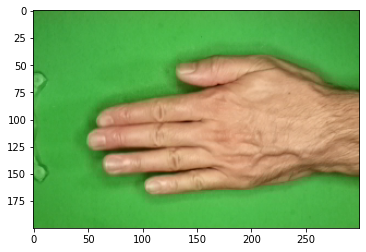

In [5]:
img = image.load_img(os.path.join(data_root,'paper','04l5I8TqdzF9WDMJ.png'))
plt.imshow(img)

In [6]:
x = image.img_to_array(img)
print(x.shape)

(200, 300, 3)


In [7]:
x = x.astype('int').reshape((1,200, 300, 3))
x.shape

(1, 200, 300, 3)

In [8]:
# random으로 밑에 것중 골라서 이미지가 증강됨
gen = ImageDataGenerator(
    rotation_range = 90,
    width_shift_range=0.4,
    height_shift_range=0.4,
    vertical_flip=True,
    horizontal_flip=True
)

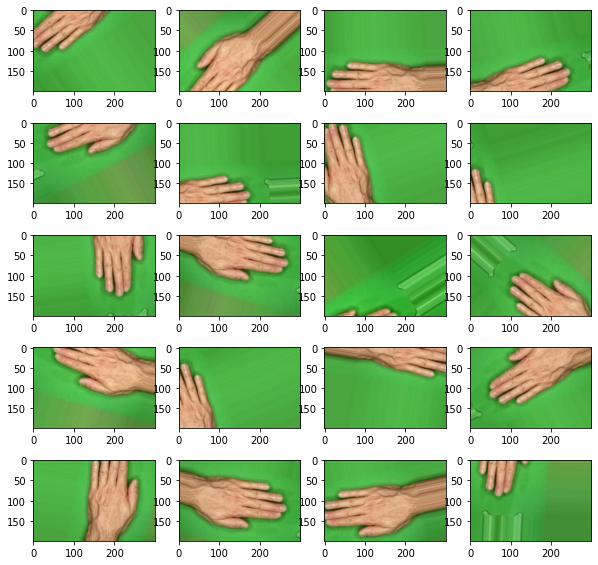

In [9]:
idx = 0
axs = []
fig = plt.figure(figsize=(10,10))
for batch in gen.flow(x,batch_size=1):
  axs.append(fig.add_subplot(5,4,idx+1))
  axs[idx].imshow(image.array_to_img(batch[0]))
  idx += 1
  if idx%20 == 0 :
    break
plt.show()

In [10]:
class_name = ['paper','rock','scissors']

In [11]:
paper_flist = os.listdir(os.path.join(data_root,'paper'))
rock_flist = os.listdir(os.path.join(data_root,'rock'))
scissors_flist = os.listdir(os.path.join(data_root,'scissors'))

print(len(paper_flist),len(rock_flist),len(scissors_flist))
print(paper_flist[0])

712 726 750
vUtM1pR6f5ZdEn5a.png


In [12]:
import os
import PIL

paper = os.path.join(data_root,'paper')
rock = os.path.join(data_root,'rock')
scissors = os.path.join(data_root,'scissors')

X = []
y = []

def datasets(flist,f_dir,label):
  for i in range(len(flist)):
    image = PIL.Image.open(os.path.join(f_dir,flist[i]))
    image = image.resize((200,200))
    arr = np.array(image)
    X.append(arr)
    y.append(label)

datasets(paper_flist,paper,0)
datasets(rock_flist,rock,1)
datasets(scissors_flist,scissors,2)

In [13]:
print(len(X),len(y))

2188 2188


In [14]:
X = np.array(X)
y = np.array(y)

In [15]:
from sklearn.model_selection import train_test_split

X_train,X_test,y_train,y_test = train_test_split(X,y,
                                             test_size=0.2,
                                             shuffle=True)

In [16]:
print(X_train.shape,y_train.shape,X_test.shape,y_test.shape)

(1750, 200, 200, 3) (1750,) (438, 200, 200, 3) (438,)


In [17]:
X_train,X_val,y_train,y_val = train_test_split(X_train,y_train,
                                             test_size=0.1,
                                             shuffle=True)

In [18]:
X_train.shape,X_val.shape

((1575, 200, 200, 3), (175, 200, 200, 3))

### 정규화 및 이미지 agumentation

In [19]:
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [20]:
train_gen = ImageDataGenerator(
    rescale=1./255.,
    rotation_range=90,
    width_shift_range=0.4,
    height_shift_range=0.4,
    vertical_flip=True,
    horizontal_flip=True
)

val_gen = ImageDataGenerator(
    rescale=1./255.
)

test_gen = ImageDataGenerator(
    rescale=1./255.
)

In [21]:
BATCH_SIZE = 32
IMAGE_SIZE = (200,200)

train_iter = train_gen.flow(
    X_train,
    y=y_train,
    batch_size=BATCH_SIZE
)

test_iter = test_gen.flow(
    X_test,
    y=y_test,
    batch_size=BATCH_SIZE
)

val_iter = val_gen.flow(
    X_val,
    y=y_val,
    batch_size=BATCH_SIZE
)

In [22]:
type(train_iter),type(val_iter),type(test_iter)

(keras.preprocessing.image.NumpyArrayIterator,
 keras.preprocessing.image.NumpyArrayIterator,
 keras.preprocessing.image.NumpyArrayIterator)

In [27]:
from tensorflow.keras.utils import to_categorical

y_train_oh = to_categorical(y_train)
y_val_oh = to_categorical(y_val)
y_test_oh = to_categorical(y_test)

In [28]:
images,labels = train_iter.next()
len(images),len(labels)

(32, 32)

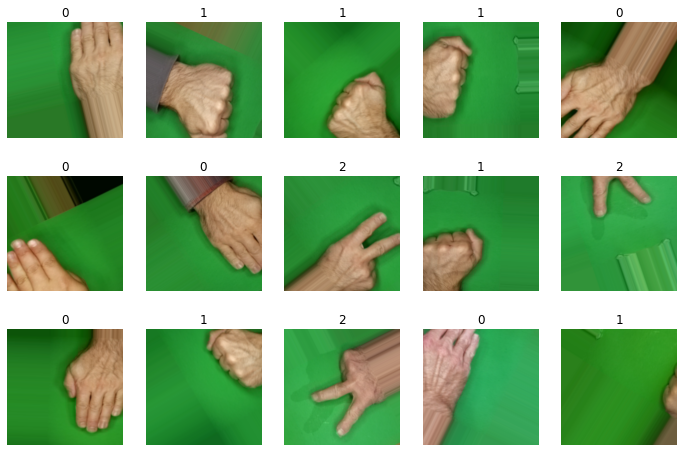

In [29]:
plt.figure(figsize=(12,8))
for i in range(15):
  plt.subplot(3,5,i+1)
  plt.axis('off')
  plt.imshow(images[i])
  plt.title(labels[i])
plt.show()

In [31]:
def build_model():
    model = keras.Sequential([
        # padding 
        # default값은 valid
        # same은 이미지 크기가 변하지 않게 패딩을 준다.
        layers.Conv2D(32, 3, activation='relu', padding='same', input_shape = (200,200,3)),
        layers.MaxPool2D(2),
        layers.Conv2D(64, 3, activation='relu', padding='same'),
        layers.MaxPool2D(2),
        layers.Conv2D(128, 3, activation='relu', padding='same'),
        layers.MaxPool2D(2),
        layers.Conv2D(128, 3, activation='relu', padding='same'),
        layers.MaxPool2D(2),

        layers.Flatten(),
        layers.Dropout(0.3),

        layers.Dense(256, activation='relu'),
        layers.Dense(3, activation='softmax')
    ])
    model.compile(
        optimizer = 'adam',
        loss = 'categorical_crossentropy',
        metrics = ['acc']
    )
    return model

### call back

In [35]:
from tensorflow.keras import callbacks

rps_path = 'rps_weigths.ckpt'
rps_callback = callbacks.ModelCheckpoint(
    rps_path,
    monitor='val_loss',
    save_weights_only = True,
    save_best_only = True,
    verbose = 1,
)

In [36]:
model = build_model()
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 200, 200, 32)      896       
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 100, 100, 32)     0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 100, 100, 64)      18496     
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 50, 50, 64)       0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (None, 50, 50, 128)       73856     
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 25, 25, 128)     

In [38]:
%%time
EPOCHS = 100
BATCH_SIZE = 32

log = model.fit(X_train,y_train_oh,
                epochs=EPOCHS,
                batch_size=BATCH_SIZE,
                callbacks=[rps_callback],
                validation_data=(X_val,y_val_oh),
                verbose=1)

Epoch 1/100
50/50 [==============================] - ETA: 0s - loss: 0.0491 - acc: 0.9841
Epoch 1: val_loss did not improve from 0.02700
50/50 [==============================] - 2s 49ms/step - loss: 0.0491 - acc: 0.9841 - val_loss: 0.0425 - val_acc: 0.9771
Epoch 2/100
50/50 [==============================] - ETA: 0s - loss: 0.0261 - acc: 0.9943
Epoch 2: val_loss did not improve from 0.02700
50/50 [==============================] - 2s 48ms/step - loss: 0.0261 - acc: 0.9943 - val_loss: 0.0406 - val_acc: 0.9829
Epoch 3/100
49/50 [============================>.] - ETA: 0s - loss: 0.0179 - acc: 0.9943
Epoch 3: val_loss did not improve from 0.02700
50/50 [==============================] - 2s 48ms/step - loss: 0.0178 - acc: 0.9943 - val_loss: 0.2010 - val_acc: 0.9600
Epoch 4/100
50/50 [==============================] - ETA: 0s - loss: 0.0357 - acc: 0.9867
Epoch 4: val_loss did not improve from 0.02700
50/50 [==============================] - 2s 48ms/step - loss: 0.0357 - acc: 0.9867 - val_los

In [39]:
## 시각화

def plot_history(history):
    hist = pd.DataFrame(history.history)
    hist['epoch'] = history.epoch

    plt.figure(figsize=(16,8))
    plt.subplot(1,2,1)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.plot(hist['epoch'], hist['loss'],label='Train Loss')
    plt.plot(hist['epoch'], hist['val_loss'],label = 'Val Loss')
    plt.legend()

    plt.subplot(1,2,2)
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.plot(hist['epoch'], hist['acc'],label='Train Accuracy')
    plt.plot(hist['epoch'], hist['val_acc'],label = 'Val Accuracy')

    plt.legend()
    plt.show()

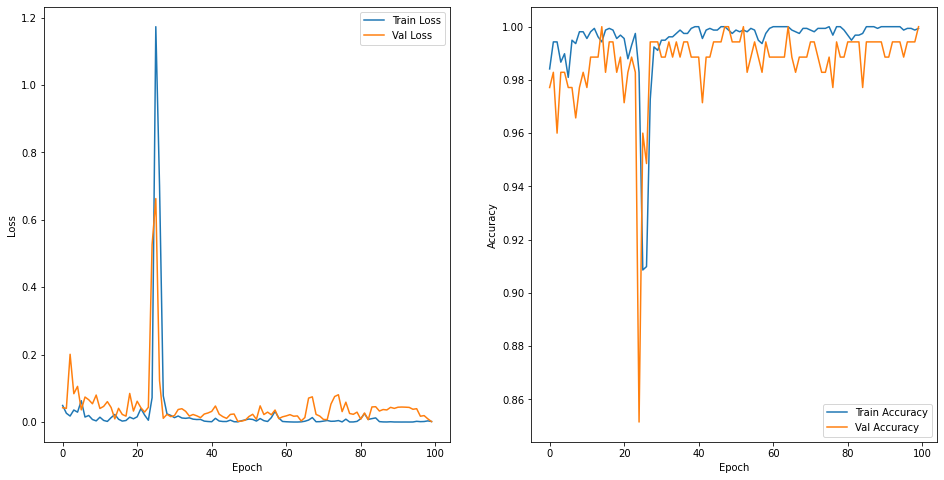

In [40]:
plot_history(log)

In [45]:
model.load_weights(rps_path)

In [46]:
model.evaluate(X_train,y_train_oh)

50/50 [==============================] - 1s 21ms/step - loss: 2.9463e-06 - acc: 1.0000


[2.9462560178217245e-06, 1.0]

In [47]:
model.evaluate(X_test,y_test_oh)

14/14 [==============================] - 0s 21ms/step - loss: 0.2626 - acc: 0.9795


[0.2626165449619293, 0.9794520735740662]

In [48]:
model.save('modle_kimtaewan.h5')